<a href="https://colab.research.google.com/github/dtoralg/IE_Calidad_ML/blob/main/Ejercicios/Modulo%206/Modulo_6_Ejercicio_1_MLP_SECOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Ejercicio 1: Introducción al Deep Learning en Clasificación Binaria Industrial**
## Aplicación de una red neuronal multicapa (MLP) al dataset SECOM



## Introducción

En este ejercicio vamos a construir y comparar modelos clásicos de Machine Learning con una red neuronal multicapa (MLP) para resolver un problema real de clasificación binaria en un entorno industrial. Utilizaremos el **SECOM Manufacturing Data Set**, que contiene medidas de sensores en un proceso de manufactura y una variable objetivo que indica si se detectó un defecto o no.

Este tipo de problema es habitual en entornos industriales donde se requiere automatizar la identificación de productos defectuosos, y el uso de redes neuronales puede aportar mejoras en la capacidad de detección frente a modelos clásicos, especialmente cuando existen relaciones no lineales entre las variables.

**Lo que aprenderás en este ejercicio:**
- Preprocesar datos reales con ruido y valores nulos.
- Entrenar y evaluar una red neuronal multicapa (MLP) usando Keras.
- Comparar su rendimiento frente a modelos clásicos como Regresión Logística y Random Forest.
- Interpretar las curvas de aprendizaje y los resultados obtenidos.


## Carga de librerías y configuración del entorno

In [1]:

# Celda 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import requests
import zipfile
import io

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


## Descripción del dataset

In [2]:
zip_url = "https://github.com/dtoralg/IE_Calidad_ML/raw/refs/heads/main/Data/Modulo%206/secom.zip"

# Descargar el zip
response = requests.get(zip_url)

# Verificar que la descarga fue exitosa
if response.status_code == 200:
    # Leer el archivo ZIP en memoria
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))

    # Mostrar el contenido del ZIP
    print("Archivos contenidos:")
    print(zip_file.namelist())

    # Extraer todos los archivos (opcional)
    zip_file.extractall("secom_data")  # Carpeta donde se guardarán
    print("Archivos extraídos en la carpeta 'secom_data'.")
else:
    print("Error al descargar el archivo:", response.status_code)


Archivos contenidos:
['secom.data', 'secom.names', 'secom_labels.data']
Archivos extraídos en la carpeta 'secom_data'.


In [3]:
# Celda 2 - Cargar y preparar features y etiquetas
import pandas as pd

# Rutas de los archivos
features_url = '/content/secom_data/secom.data'
labels_url = '/content/secom_data/secom_labels.data'

# Cargar las features
X = pd.read_csv(..., sep='\s+', header=None)
# Renombrar columnas solo si el número coincide
X.columns = [f'var_{i}' for i in range(X.shape[1])]

# Cargar las etiquetas y fechas
y = pd.read_csv(..., sep='\s+', header=None)
y.columns = ['label', 'timestamp']  # Añadir nombres de columna
y['label'] = ... # Reemplaza los valores de y por valores binarios 0,1


# Verificar
print("Dimensiones de X:", X.shape)
...

Dimensiones de X: (1567, 590)


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_580,var_581,var_582,var_583,var_584,var_585,var_586,var_587,var_588,var_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [4]:
print("Dimensiones de y:", y.shape)
...

Dimensiones de y: (1567, 2)


,label,timestamp
0,0,19/07/2008 11:55:00
1,0,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,0,19/07/2008 14:43:00
4,0,19/07/2008 15:22:00


## Preprocesamiento de datos

In [5]:
# Celda 3
# Verificar nulos
...

Porcentaje de valores nulos por variable (top 10):
var_292    0.911934
var_293    0.911934
var_158    0.911934
var_157    0.911934
var_492    0.855775
var_85     0.855775
var_358    0.855775
var_220    0.855775
var_244    0.649649
var_517    0.649649
dtype: float64


In [6]:
# Celda 4
# Eliminar columnas con más del 25% de nulos
...

# Imputar el resto con la media
...

# Escalado
...


In [7]:
# Celda 5 Train, test split. Atención al balanceo de la variable target.
...

# Aplicar SMOTE solo al conjunto de entrenamiento
...

# Verificar balance
...

,proportion
label,
0,0.5
1,0.5


## Entrenamiento de modelos clásicos

In [8]:

# Celda 6
# Regresión Logística, fit y predicciones
...

print("Logistic Regression F1 Score:", f1_score(y_test, lr_preds))

Logistic Regression F1 Score: 0.10714285714285714


## Entrenamiento de red neuronal (MLP)

In [9]:
# Celda 7. Crea una red neuronal, prueba con distintas combinaciones de capas
model = Sequential()
model.add(...)
# Utiliza la red de salida adecuada (clasificación binaria)
model.add(...)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Celda 8

# Por su desbalanceo, usaremos los pesos de clase calculados automáticamente
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))
print("Pesos de clase:", class_weights)

early_stopping = EarlyStopping(
    monitor=...,
    patience=...,
    restore_best_weights=...,
    verbose=...
)

# Entrenamiento del modelo con class_weight
history = model.fit(
    ...,
    ...,
    validation_data=(X_test, y_test),
    epochs=...,
    batch_size=...,
    class_weight=...,
    callbacks=[...],
    verbose=1
)


Pesos de clase: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}
Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7698 - loss: 0.4882 - val_accuracy: 0.9236 - val_loss: 0.3090
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0728 - val_accuracy: 0.9172 - val_loss: 0.4089
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0228 - val_accuracy: 0.9172 - val_loss: 0.4859
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0078 - val_accuracy: 0.9172 - val_loss: 0.5253
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9172 - val_loss: 0.5501
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9172 - val_loss: 0.5815
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9172 - val_loss: 0.6090
Epoch 8/100
147/147

## Evaluación de resultados y comparación

In [11]:
# Celda 9
# Lanza predicciones y después define un umbral a partir del cual predecimos una clase como positiva
y_pred_prob = model.predict(X_test)
y_pred_class = (y_pred_prob > ...).astype(int)

print("Matriz de Confusión:")
print(...)

print("\nReporte de Clasificación:")
print(...)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Matriz de Confusión:
[[274  19]
 [ 17   4]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       293
           1       0.17      0.19      0.18        21

    accuracy                           0.89       314
   macro avg       0.56      0.56      0.56       314
weighted avg       0.89      0.89      0.89       314



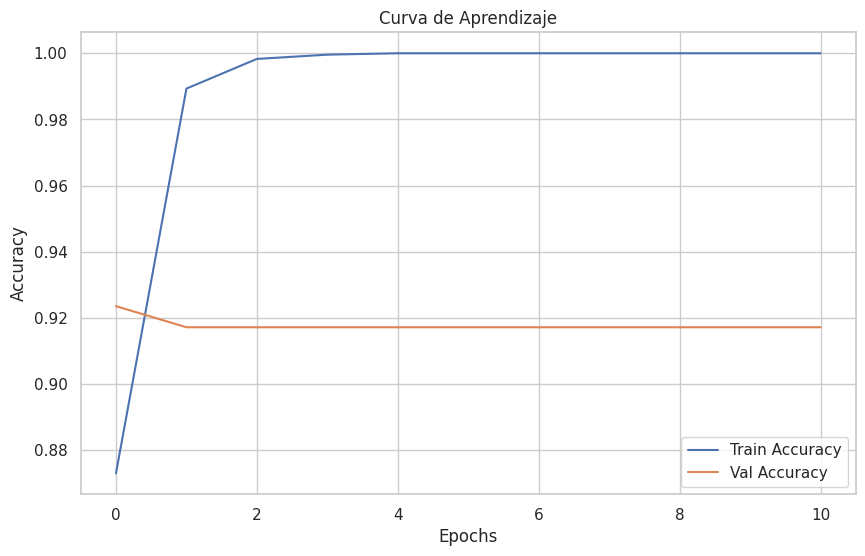

In [12]:
# Celda 10
# Curvas de entrenamiento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Curva de Aprendizaje")
plt.show()

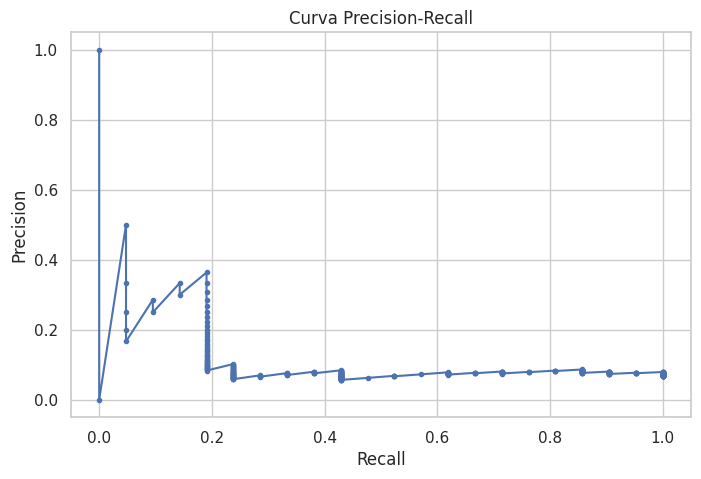

In [13]:
# Celda 11
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

## Conclusiones


**Resumen de lo aprendido:**
- Hemos entrenado una red neuronal simple y modelos clásicos sobre datos industriales reales.
- El dataset SECOM tiene ruido y desequilibrios que afectan el rendimiento, pero la red neuronal ha logrado resultados mucho mejores que la regresión.
- La preparación de datos (tratamiento de nulos, escalado, SMOTE) ha sido esencial para lograr buenos resultados.

**Próximos pasos sugeridos:**
1. Ajustar los hiperparámetros de la red neuronal con búsqueda en grid.
3. Probar arquitecturas más profundas o usar técnicas de regularización como dropout.

**Licencia del dataset:** SECOM Manufacturing Data Set — Fuente: UCI ML Repository, Licencia: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
